In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.ensemble
import pathlib

# Local imports
import annotation, hyspec_cnn

In [2]:
# Disable GPUs (in case of Tensorflow trying to use GPUs and raising errors)
tf.config.set_visible_devices([], 'GPU')

2023-05-02 17:12:28.662130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 17:12:28.731388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 17:12:28.731720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# Parameters
VAL_FRAC = 0.3
BATCH_SIZE = 4

In [4]:
# Paths 
base_dir = pathlib.Path('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS')
tiles_dataset_path = base_dir / '5c_Rad_Georef_SGC_PCA_Tiles/20210825_Olberg_PCA_TrainValDataset'
class_dict_path =  base_dir / '4c_Rad_Georef_SGC_Tiles/tile_classes_merged_NGT.json'
unet_model_save_dir = base_dir /  'X_SavedKerasModels'
tensorboard_log_dir = base_dir / 'X_TensorboardLogs'

In [5]:
# Load class label dictionary
class_dict = {'Background':0}
class_dict.update(annotation.read_class_dict(class_dict_path))
for key,value in class_dict.items():
    print(f'{key}: {value}')

Background: 0
Sand: 1
Zostera marina: 2
Zostera marina with turf algae: 3
Rockweed: 4
Other algae: 5


In [6]:
tiles_dataset_path

PosixPath('/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/5c_Rad_Georef_SGC_PCA_Tiles/20210825_Olberg_PCA_TrainValDataset')

In [7]:
# Load dataset (or, rather, pointer to dataset)
dataset = tf.data.experimental.load(str(tiles_dataset_path))

2023-05-02 17:12:43.507746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Show dataset details
n_tiles = int(dataset.cardinality())
print(f'Dataset specification: {dataset}')
print(f'Number of tiles: {n_tiles}')

Dataset specification: <_LoadDataset element_spec=(TensorSpec(shape=(128, 128, 8), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128), dtype=tf.int32, name=None))>
Number of tiles: 459


In [9]:
# Get dataset shape
tile_nrows,tile_ncols,tile_nchannels = dataset.element_spec[0].shape.as_list()
print(f'{tile_nrows=}, {tile_ncols=}, {tile_nchannels=}')

tile_nrows=128, tile_ncols=128, tile_nchannels=8


In [10]:
# From https://www.tensorflow.org/tutorials/images/segmentation#optional_imbalanced_classes_and_class_weights
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([0.0, 1.0, 1.0, 1.0, 1.0, 1.0]) # Hard-coded for current dataset, zero weight for background
    class_weights = class_weights/tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an 
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

In [11]:
# Shuffle dataset (tiles are originally ordered by image) and add sample weights
dataset = dataset.shuffle(buffer_size=n_tiles)
dataset = dataset.map(add_sample_weights)

In [12]:
# Split dataset into training and validation
# Note: Doing K-fold validation on Tensorflow datasets is not straightforward,
# but can probably be done using generators. We'll do a simple split for now.
n_val_tiles = int(VAL_FRAC*n_tiles)
validation_dataset = dataset.take(n_val_tiles).batch(BATCH_SIZE)
training_dataset = dataset.skip(n_val_tiles).batch(BATCH_SIZE)
print(f'Number of batches in training dataset: {training_dataset.cardinality()}')
print(f'Number of batches in validation dataset: {validation_dataset.cardinality()}')

Number of batches in training dataset: 81
Number of batches in validation dataset: 35


In [13]:
# Create the U-Net model
unet = hyspec_cnn.unet(input_channels=tile_nchannels,
                       output_channels=len(class_dict),
                       first_layer_channels=32,
                       depth = 5,
               )
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 8)]                                                              
                                                                                                  
 augmentation (Sequential)      (None, None, None,   0           ['input_image[0][0]']            
                                8)                                                                
                                                                                                  
 initial_convolution (Conv2D)   (None, None, None,   2336        ['augmentation[0][0]']           
                                32)                                                           

In [18]:
tmp = unet.layers[3]

In [19]:
tmp.layers

In [26]:
for layer in unet.layers:
    print('----')
    print(layer.name)
    if hasattr(layer,'layers'):
        for l in layer.layers:
            print('\t'+l.name)
       # print(layer.layers)

----
input_image
----
augmentation
	random_flip
----
initial_convolution
----
downsamp_res_1/2
	conv2d
	batch_normalization
	leaky_re_lu
----
downsamp_res_1/4
	conv2d_1
	batch_normalization_1
	leaky_re_lu_1
----
downsamp_res_1/8
	conv2d_2
	batch_normalization_2
	leaky_re_lu_2
----
downsamp_res_1/16
	conv2d_3
	batch_normalization_3
	leaky_re_lu_3
----
downsamp_res_1/32
	conv2d_4
	batch_normalization_4
	leaky_re_lu_4
----
upsamp_res_1/16
	conv2d_transpose
	batch_normalization_5
	re_lu
----
skipconnection_res_1/16
----
upsamp_res_1/8
	conv2d_transpose_1
	batch_normalization_6
	re_lu_1
----
skipconnection_res_1/8
----
upsamp_res_1/4
	conv2d_transpose_2
	batch_normalization_7
	re_lu_2
----
skipconnection_res_1/4
----
upsamp_res_1/2
	conv2d_transpose_3
	batch_normalization_8
	re_lu_3
----
skipconnection_res_1/2
----
upsamp_res_1/1
	conv2d_transpose_4
	batch_normalization_9
	re_lu_4
----
skipconnection_res_1/1
----
classification


In [15]:
# Define callbacks
model_save_filename = str(unet_model_save_dir) + '/unet_model.epoch{epoch:02d}-loss{val_loss:.3f}-acc{val_sparse_categorical_accuracy:.3f}.hdf5'
callbacks =[tf.keras.callbacks.ModelCheckpoint(filepath = model_save_filename,
                                   verbose = 1),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
            tf.keras.callbacks.TensorBoard(log_dir= tensorboard_log_dir)]

In [16]:
unet.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001), 
             loss="sparse_categorical_crossentropy",
             weighted_metrics=[],
             metrics = ['sparse_categorical_accuracy']) # Sparse because classes are numbered, not one-hot

In [17]:
# Fit model to dataset
history = unet.fit(training_dataset,
                   epochs=150,
                   validation_data=validation_dataset,
                   callbacks=callbacks)

Epoch 1/150
81/81 [==============================] - ETA: 0s - loss: 0.1305 - sparse_categorical_accuracy: 0.2172
Epoch 1: saving model to /media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/X_SavedKerasModels/unet_model.epoch01-loss0.109-acc0.227.hdf5
81/81 [==============================] - 85s 999ms/step - loss: 0.1305 - sparse_categorical_accuracy: 0.2172 - val_loss: 0.1087 - val_sparse_categorical_accuracy: 0.2268 - lr: 1.0000e-04
Epoch 2/150
81/81 [==============================] - ETA: 0s - loss: 0.0811 - sparse_categorical_accuracy: 0.2227
Epoch 2: saving model to /media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/X_SavedKerasModels/unet_model.epoch02-loss0.058-acc0.273.hdf5
81/81 [==============================] - 81s 1s/step - loss: 0.0811 - sparse_categorical_accuracy: 0.2227 - val_loss: 0.0581 - val_sparse_categorical_accuracy: 0.2728 - lr: 1.0000e-04
Epoch 3/150
81/81 [==============================] - ETA: 0s - loss: 0.0690 - spars

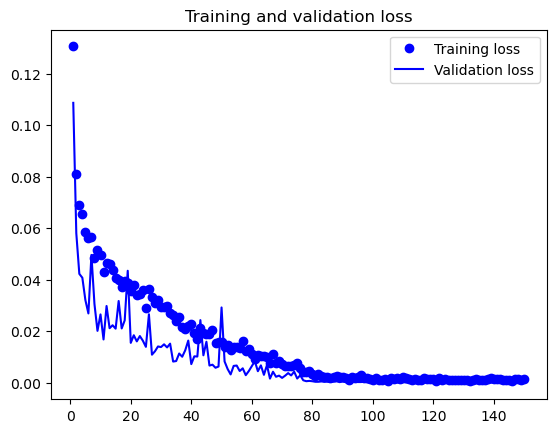

In [18]:
epochs = range(1, history.params['epochs'] + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

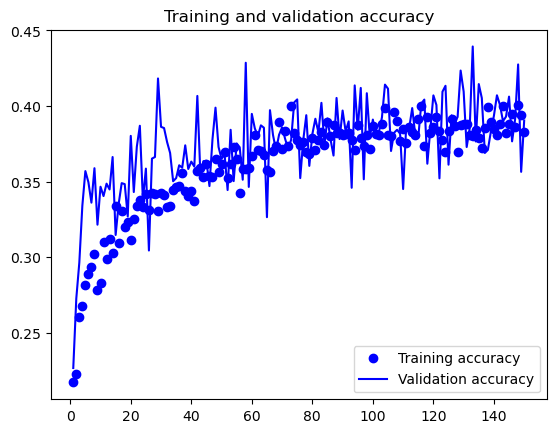

In [19]:
epochs = range(1, history.params['epochs'] + 1)
train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

plt.figure()
plt.plot(epochs, train_acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()